---
title: "Paper Replication: Vision Transformer"
description: |
  The first in a series of paper replications that will collectively lay the foundation for a full replication of the stable diffusion model from scratch.
author:
  - name: Jake Gehri
    url: {}
date: "2022-12-9"
categories: ["Python", "Deep Learning", "Computer Vision"]
image: vit.png
format: 
  html:
    df-print: paged
    toc: true
engine: knitr
---

In [311]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
from torchmetrics import Accuracy
from torchvision import transforms
from torchinfo import summary

In [252]:
train_split_len = 1000
trainset = torchvision.datasets.CIFAR10(root = 'data', train = True, download=True, transform = ToTensor())
part_train = torch.utils.data.random_split(trainset, [train_split_len, len(trainset)-train_split_len])[0]
trainloader = DataLoader(part_train, batch_size=25, shuffle=True)

Files already downloaded and verified


In [254]:
test_split_len = 200
testset = torchvision.datasets.CIFAR10(root = 'data', train = False, download=True, transform = ToTensor())
part_test = torch.utils.data.random_split(testset, [test_split_len, len(testset)-test_split_len])[0]
testloader = DataLoader(part_test, batch_size=25, shuffle=True)

Files already downloaded and verified


In [255]:
classes = testset.class_to_idx
classes

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [256]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [257]:
images.shape, labels.shape

(torch.Size([25, 3, 32, 32]), torch.Size([25]))

automobile


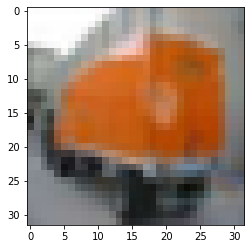

In [258]:
print(list(classes.keys()) [list(classes.values()).index(1)])
plt.imshow(images[1].permute(1,2,0).numpy())

In [260]:
class LinearProjectionBlock(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 2, embedding_dim = 768, batch_size=25, num_patches=256):
        super().__init__()
        self.patch = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        self.class_token = nn.Parameter(torch.rand(batch_size, 1, embedding_dim), requires_grad=True)
        
        self.positional = nn.Parameter(torch.rand(batch_size, num_patches+1, embedding_dim), requires_grad=True)
        
        
    def forward(self, x):
        
        x = self.patch(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = torch.cat((self.class_token, x), dim=1)
        x = self.positional + x
        return x
        

In [261]:
class MSABlock(nn.Module):
    def __init__(self, embedding_dim = 768, num_heads=12):
        super().__init__()
        self.normalize = nn.LayerNorm(normalized_shape=embedding_dim)
        self.msa = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads = num_heads, batch_first=True)
        
    def forward(self, x):
        x = self.normalize(x)
        x, _ = self.msa(query=x, key=x, value=x, need_weights=False)
        return x

In [262]:
lin_projs = LinearProjectionBlock(in_channels=3, patch_size=2, embedding_dim=768, batch_size=25, num_patches=256)

In [263]:
projs = lin_projs(images)

In [264]:
projs.shape

torch.Size([25, 257, 768])

In [265]:
msa_block = MSABlock(embedding_dim=768, num_heads=12)

In [266]:
out = msa_block(projs)

In [267]:
out.shape

torch.Size([25, 257, 768])

In [268]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim = 768, mlp_size = 3072):
        super().__init__()
        self.normalize = nn.LayerNorm(embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(0.1)
        )
        
    def forward(self, x):
        x = self.normalize(x)
        x = self.mlp(x)
        return x

In [269]:
class TrasformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim = 768, num_heads=12, mlp_size=3072):
        super().__init__()
        self.msa_block = MSABlock(embedding_dim = embedding_dim, num_heads=num_heads)
        
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim, mlp_size = mlp_size)
        
    def forward(self, x):
        x = self.msa_block(x)

        x = self.mlp_block(x)

        return x

In [270]:
mlp = MLPBlock(embedding_dim=768)

In [271]:
fout = mlp(out)

In [317]:
class ViT(nn.Module):
    def __init__(self, img_size = 32, in_channels = 3, patch_size = 2, embedding_dim = 768, 
                 batch_size=25, num_patches=256, mlp_size = 3072, layers = 12, num_heads=12, num_classes=10):
        super().__init__()
        
        self.projections = LinearProjectionBlock(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim, batch_size=batch_size, num_patches=num_patches)
        
        self.transformer_encoder = nn.TransformerEncoderLayer(d_model=embedding_dim, 
                                                             nhead=num_heads, 
                                                             dim_feedforward=mlp_size, 
                                                             dropout=0.1, 
                                                             activation="gelu", 
                                                             batch_first=True, 
                                                             norm_first=True)
        self.encoder_layer = nn.TransformerEncoder(self.transformer_encoder, num_layers=layers)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        
        )
    
    def forward(self, x, layers=12):
        x = self.projections(x)
        x = self.encoder_layer(x)
        x = self.classifier(x[:, 0])
        return x
        

In [318]:
vit = ViT(in_channels = 3, patch_size = 4, embedding_dim = 768, batch_size=25, num_patches=64, mlp_size = 2048).to('cuda')

In [319]:
summary(vit, input_size=(25, 3, 32, 32),col_names=["input_size"])

Layer (type:depth-idx)                        Input Shape
ViT                                           [25, 3, 32, 32]
├─LinearProjectionBlock: 1-1                  [25, 3, 32, 32]
│    └─Conv2d: 2-1                            [25, 3, 32, 32]
│    └─Flatten: 2-2                           [25, 768, 8, 8]
├─TransformerEncoder: 1-2                     [25, 65, 768]
│    └─ModuleList: 2-3                        --
│    │    └─TransformerEncoderLayer: 3-1      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-2      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-3      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-4      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-5      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-6      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-7      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-8      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-9      [25, 65, 768]
│    │    └─TransformerEncoderLayer: 3-10    

In [320]:
test_output = vit(images.to('cuda'))

In [321]:
test_output.shape

torch.Size([25, 10])

In [322]:
torch.argmax(test_output[1]), labels[1]

(tensor(0, device='cuda:0'), tensor(9))

In [323]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)
accuracy = Accuracy(task="multiclass", num_classes=10)

In [324]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to('cuda'), y.to('cuda')

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [325]:
def test_step(model, dataloader, loss_fn):
    
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to('cuda'), y.to('cuda')
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
def train(model,train_dataloader,test_dataloader, optimizer, loss_fn, epochs = 50):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [328]:
results = train(model=vit, train_dataloader=trainloader, test_dataloader=testloader, optimizer=optimizer, loss_fn=loss_fn, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3983 | train_acc: 0.1070 | test_loss: 2.3546 | test_acc: 0.0750
Epoch: 2 | train_loss: 2.4793 | train_acc: 0.1120 | test_loss: 2.4665 | test_acc: 0.1100
Epoch: 3 | train_loss: 2.4430 | train_acc: 0.1060 | test_loss: 2.3757 | test_acc: 0.0900
Epoch: 4 | train_loss: 2.3699 | train_acc: 0.1010 | test_loss: 2.3697 | test_acc: 0.1050
Epoch: 5 | train_loss: 2.3734 | train_acc: 0.1100 | test_loss: 2.3556 | test_acc: 0.1450
Epoch: 6 | train_loss: 2.3820 | train_acc: 0.0850 | test_loss: 2.3614 | test_acc: 0.0800
Epoch: 7 | train_loss: 2.3696 | train_acc: 0.0810 | test_loss: 2.3599 | test_acc: 0.1000
Epoch: 8 | train_loss: 2.3491 | train_acc: 0.0960 | test_loss: 2.3836 | test_acc: 0.1200
Epoch: 9 | train_loss: 2.3625 | train_acc: 0.1030 | test_loss: 2.3677 | test_acc: 0.0500
Epoch: 10 | train_loss: 2.3425 | train_acc: 0.1120 | test_loss: 2.3327 | test_acc: 0.1100
Epoch: 11 | train_loss: 2.3501 | train_acc: 0.1020 | test_loss: 2.3617 | test_acc: 0.1050
Epoch: 12 | train_l

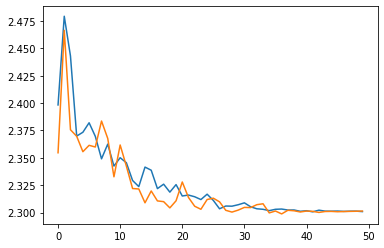

In [329]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])

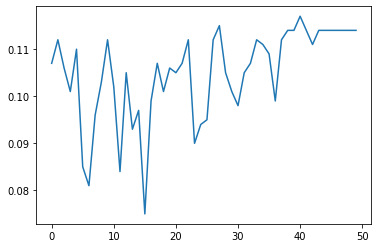

In [330]:
plt.plot(results['train_acc'])